In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt

In [2]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [3]:
# Download historical data (monthly) for DJI constituent stocks

tickers = ["MMM","AXP","T","BA","CAT","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UNH","VZ","V","WMT","DIS"]

ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

### Backtesting

In [14]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)

In [15]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

In [16]:
#calculating overall strategy's KPIs
print("CAGR for the portfolio is ",CAGR(pflio(return_df,6,3)))
print("Sharpe Ratio for the portfolio is ",sharpe(pflio(return_df,6,3),0.025))
print("Max Drawdown for the portfolio was ",max_dd(pflio(return_df,6,3))) 

CAGR for the portfolio is  0.12108637667080191
Sharpe Ratio for the portfolio is  0.5659273133284903
Max Drawdown for the portfolio was  0.27012763200853135


In [17]:
#calculating KPIs for Index buy and hold strategy over the same period
DJI = yf.download("^DJI",dt.date.today()-dt.timedelta(3650),dt.date.today(),interval='1mo')
DJI["mon_ret"] = DJI["Adj Close"].pct_change().fillna(0)
print("CAGR for DJI was ", CAGR(DJI))
print("Sharpe Ratio for DJI was ", sharpe(DJI,0.025))
print("Max Drawdown for DJI was ",max_dd(DJI))

[*********************100%%**********************]  1 of 1 completed
CAGR for DJI was  0.0855150857543947
Sharpe Ratio for DJI was  0.39851209584630504
Max Drawdown for DJI was  0.23201266165063428


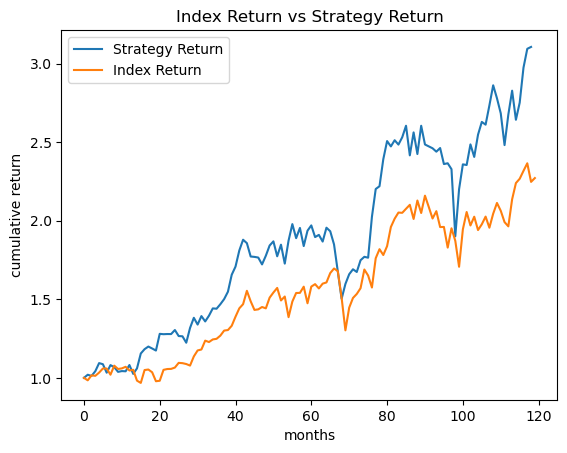

In [18]:
#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])